In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

# Tutorial - Training a model on Imagenette

> A dive into the layered API of fastai in computer vision

In [ ]:
# all_slow

The fastai library as a layered API as summarized by this graph:

![A layered API](images/layered.png)

If you are following this tutorial, you are probably already familiar with the applications, here we will see how they are powered by the high-level and mid-level API. 

[Imagenette](https://github.com/fastai/imagenette) is a subset of ImageNet with 10 very different classes. It's great to quickly experiment before trying a fleshed-out technique on the full ImageNet dataset. We will show in this tutorial how to train a model on it, using the usual high-level APIs, then delving inside the fastai library to show you how to use the mid-level APIs we designed. This way you'll be able to customize your own data collection or training as needed. 

## Assemble the data

We will look at several ways to get our data in `DataLoaders`: first we will use `ImageDataLoaders` factory methods (application layer), then the data block API (high level API) and lastly, how to do the same thing with the mid-level API.

### Loading the data with a factory method

This is the most basic way of assembling the data that we have presented in all the beginner tutorials, so hopefully it should be familiar to you by now.

First, we import everything inside the vision application:

In [ ]:
from fastai.vision.all import *

Matplotlib is building the font cache using fc-list. This may take a moment.


Then we download the dataset and decompress it (if needed) and get its location:

In [ ]:
path = untar_data(URLs.IMAGENETTE_160)

We use `ImageDataLoaders.from_folder` to get everything (since our data is organized in an imageNet-style format):

In [ ]:
dls = ImageDataLoaders.from_folder(path, valid='val', 
    item_tfms=RandomResizedCrop(128, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))

And we can have a look at our data:

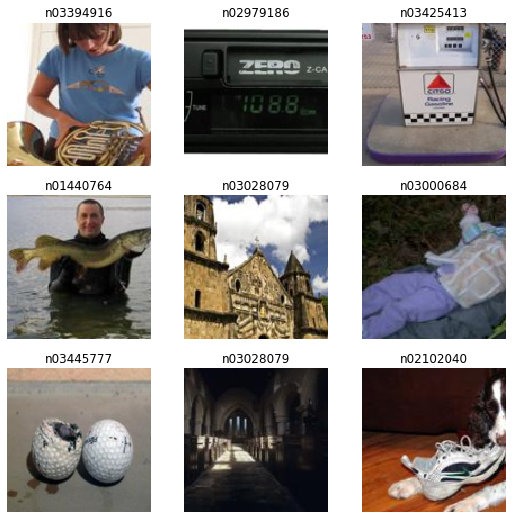

In [ ]:
dls.show_batch()

### Loading the data with the data block API

And as we saw in previous tutorials, the `get_image_files` function helps get all the images in subfolders:

In [ ]:
fnames = get_image_files(path)

Let's begin with an empty `DataBlock`.

In [ ]:
dblock = DataBlock()

By itself, a `DataBlock` is just a blue print on how to assemble your data. It does not do anything until you pass it a source. You can choose to then convert that source into a `Datasets` or a `DataLoaders` by using the `DataBlock.datasets` or `DataBlock.dataloaders` method. Since we haven't done anything to get our data ready for batches, the `dataloaders` method will fail here, but we can have a look at how it gets converted in `Datasets`. This is where we pass the source of our data, here all of our filenames:

In [ ]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03000684/n03000684_14453.JPEG'),
 Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03000684/n03000684_14453.JPEG'))

By default, the data block API assumes we have an input and a target, which is why we see our filename repeated twice. 

The first thing we can do is to use a `get_items` function to actually assemble our items inside the data block:

In [ ]:
dblock = DataBlock(get_items = get_image_files)

The difference is that you then pass as a source the folder with the images and not all the filenames:

In [ ]:
dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03425413/n03425413_16978.JPEG'),
 Path('/home/sgugger/.fastai/data/imagenette2-160/train/n03425413/n03425413_16978.JPEG'))

Our inputs are ready to be processed as images (since images can be built from filenames), but our target is not. We need to convert that filename to a class name. For this, fastai provides `parent_label`:

In [ ]:
parent_label(fnames[0])

'n03425413'

This is not very readable, so since we can actually make the function we want, let's convert those obscure labels to something we can read:

In [ ]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

In [ ]:
def label_func(fname):
    return lbl_dict[parent_label(fname)]

We can then tell our data block to use it to label our target by passing it as `get_y`:

In [ ]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(Path('/home/sgugger/.fastai/data/imagenette2-160/val/n01440764/n01440764_9931.JPEG'),
 'tench')

Now that our inputs and targets are ready, we can specify types to tell the data block API that our inputs are images and our targets are categories. Types are represented by blocks in the data block API, here we use `ImageBlock` and `CategoryBlock`:

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=240x160, TensorCategory(0))

We can see how the `DataBlock` automatically added the transforms necessary to open the image, or how it changed the name "cat" to an index (with a special tensor type). To do this, it created a mapping from categories to index called "vocab" that we can access this way:

In [ ]:
dsets.vocab

(#10) ['English springer','French horn','cassette player','chain saw','church','garbage truck','gas pump','golf ball','parachute','tench']

Note that you can mix and match any block for input and targets, which is why the API is named data block API. You can also have more than two blocks (if you have multiple inputs and/or targets), you would just need to pass `n_inp` to the `DataBlock` to tell the library how many inputs there are (the rest would be targets) and pass a list of functions to `get_x` and/or `get_y` (to explain how to process each item to be ready for its type). See the object detection below for such an example.

The next step is to control how our validation set is created. We do this by passing a `splitter` to `DataBlock`. For instance, here is how we split by grandparent folder.

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter())

dsets = dblock.datasets(path)
dsets.train[0]

(PILImage mode=RGB size=160x357, TensorCategory(6))

The last step is to specify item transforms and batch transforms (the same way as we do it in `ImageDataLoaders` factory methods):

In [ ]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = GrandparentSplitter(),
                   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
                   batch_tfms=Normalize.from_stats(*imagenet_stats))

With that resize, we are now able to batch items together and can finally call `dataloaders` to convert our `DataBlock` to a `DataLoaders` object:

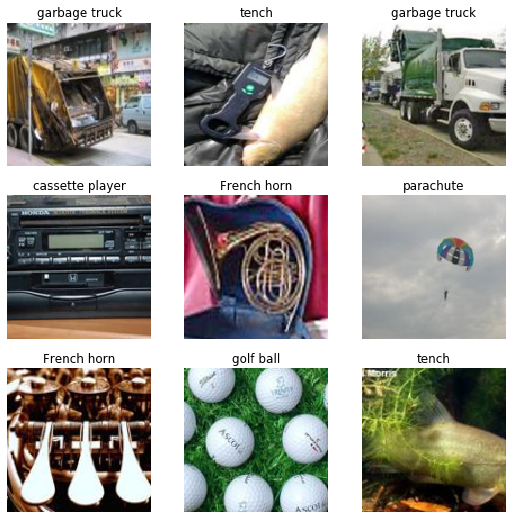

In [ ]:
dls = dblock.dataloaders(path)
dls.show_batch()

Another way to compose several functions for `get_y` is to put them in a `Pipeline`:

In [ ]:
imagenette = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = Pipeline([parent_label, lbl_dict.__getitem__]),
                       splitter = GrandparentSplitter(valid_name='val'),
                       item_tfms = RandomResizedCrop(128, min_scale=0.35),
                       batch_tfms = Normalize.from_stats(*imagenet_stats))

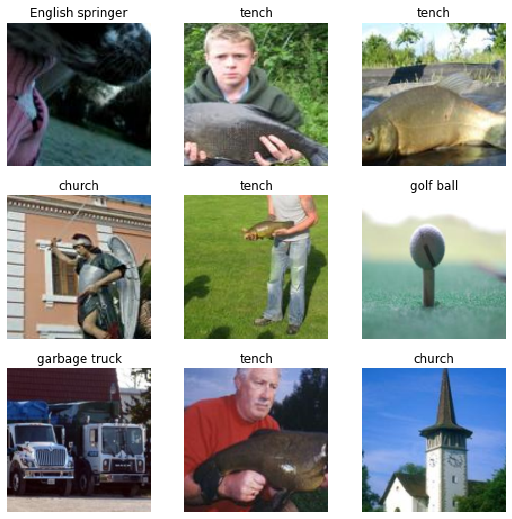

In [ ]:
dls = imagenette.dataloaders(path)
dls.show_batch()

To learn more about the data block API, checkout the [data block tutorial](http://docs.fast.ai/tutorial.datablock)!

### Loading the data with the mid-level API

Now let's see how we can load the data with the medium-level API: we will learn about `Transform`s and `Datasets`. The beginning is the same as before: we download our data and get all our filenames:

In [ ]:
source = untar_data(URLs.IMAGENETTE_160)
fnames = get_image_files(source)

Every bit of transformation we apply to our raw items (here the filenames) is called a `Transform` in fastai. It's basically a function with a bit of added functionality:

- it can have different behavior depending on the type it receives (this is called type dispatch)
- it will generally be applied on each element of a tuple

This way, when you have a `Transform` like resize, you can apply it on a tuple (image, label) and it will resize the image but not the categorical label (since there is no implementation of resize for categories). The exact same transform applied on a tuple (image, mask) will resize the image and the target, using bilinear interpolation on the image and nearest neighbor on the mask. This is how the library manages to always apply data augmentation transforms on every computer vision application (segmentation, point localization or object detection).

Additionally, a transform can have

- a setup executed on the whole set (or the whole training set). This is how `Categorize` builds it vocabulary automatically.
- a decodes that can undo what the transform does for showing purposes (for instance `Categorize` will convert back an index into a category).

We won't delve into those bits of the low level API here, but you can check out the [pets tutorial](http://docs.fast.ai/tutorial.pets) or the more advanced [siamese tutorial](http://docs.fast.ai/tutorial.siamese) for more information.

To open an image, we use the `PILImage.create` transform. It will open the image and make it of the fastai type `PILImage`:

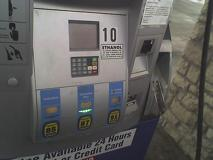

In [ ]:
PILImage.create(fnames[0])

In parallel, we have already seen how to get the label of our image, using `parent_label` and `lbl_dict`:

In [ ]:
lbl_dict[parent_label(fnames[0])]

'gas pump'

To make them proper categories that are mapped to an index before being fed to the model, we need to add the `Categorize` transform. If we want to apply it directly, we need to give it a vocab (so that it knows how to associate a string with an int). We already saw that we can compose several transforms by using a `Pipeline`:

In [ ]:
tfm = Pipeline([parent_label, lbl_dict.__getitem__, Categorize(vocab = lbl_dict.values())])
tfm(fnames[0])

TensorCategory(6)

Now to build our `Datasets` object, we need to specify:

- our raw items
- the list of transforms that builds our inputs from the raw items
- the list of transforms that builds our targets from the raw items
- the split for training and validation

We have everything apart from the split right now, which we can build this way:

In [ ]:
splits = GrandparentSplitter(valid_name='val')(fnames)

We can then pass all of this information to `Datasets`.

In [ ]:
dsets = Datasets(fnames, [[PILImage.create], [parent_label, lbl_dict.__getitem__, Categorize]], splits=splits)

The main difference with what we had before is that we can just pass along `Categorize` without passing it the vocab: it will build it from the training data (which it knows from `items` and `splits`) during its setup phase. Let's have a look at the first element:

In [ ]:
dsets[0]

(PILImage mode=RGB size=213x160, TensorCategory(6))

We can also use our `Datasets` object to represent it:

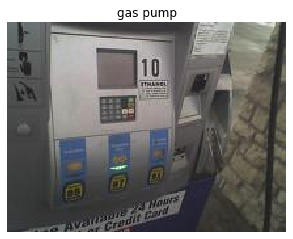

In [ ]:
dsets.show(dsets[0]);

Now if we want to build a `DataLoaders` from this object, we need to add a few transforms that will be applied at the item level> As we saw before, those transforms will be applied separately on the inputs and targets, using the appropriate implementation for each type (which can very well be don't do anything).

Here we need to:

- resize our images
- convert them to tensors

In [ ]:
item_tfms = [ToTensor, RandomResizedCrop(128, min_scale=0.35)]

Additionally we will need to apply a few transforms on the batch level, namely:

- convert the int tensors from images to floats, and divide every pixel by 255
- normalize using the imagenet statistics

In [ ]:
batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]

Those two bits could be done per item as well, but it's way more efficient to do it on a full batch. 

Note that we have more transforms than in the data block API: there was no need to think of `ToTensor` or `IntToFloatTensor` there. This is because data blocks come with default item transforms and batch transforms when it concerns transforms you will always need with that type. 

When passing those transforms to the `.dataloaders` method, the corresponding arguments have a slightly different name: the `item_tfms` are passed to `after_item` (because they are applied after the item has been formed) and the `batch_tfms` are passed to `after_batch` (because they are applied after the batch has been formed).

In [ ]:
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64, num_workers=8)

We can then use the traditional `show_batch` method:

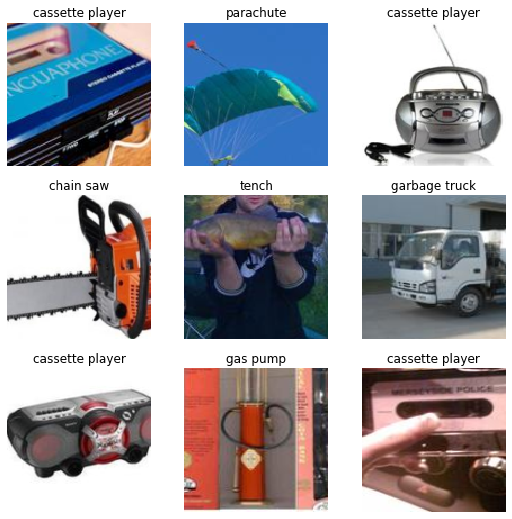

In [ ]:
dls.show_batch()

## Training

We will start with the usual `cnn_learner` function we used in the [vision tutorial](http://docs.fast.ai/tutorial.vision), we will see how one can build a `Learner` object in fastai. Then we will learn how to customize 

- the loss function and how to write one that works fully with fastai,
- the optimizer function and how to use PyTorch optimizers,
- the training loop and how to write a basic `Callback`.

### Building a `Learner`

The easiest way to build a `Learner` for image classification, as we have seen, is to use `cnn_learner`. We can specify that we don't want a pretrained model by passing `pretrained=False` (here the goal is to train a model from scratch):

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)

And we can fit our model as usual:

In [ ]:
#slow
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.465585,2.208060,0.294777,00:11
1,2.404608,2.001794,0.298854,00:11
2,2.034411,2.155173,0.370191,00:10
3,1.763775,1.583585,0.487643,00:11
4,1.543254,1.421870,0.528408,00:13


That's a start. But since we are not using a pretrained model, why not use a different architecture? fastai comes with a version of the resnets models that have all the tricks from modern research incorporated. While there is no pretrained model using those at the time of writing this tutorial, we can certainly use them here. For this, we just need to use the `Learner` class. It takes our `DataLoaders` and a PyTorch model, at the minimum. Here we can use `xresnet34` and since we have 10 classes, we specify `n_out=10`:

In [ ]:
learn = Learner(dls, xresnet34(n_out=10), metrics=accuracy)

We can find a good learning rate with the learning rate finder:

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0010000000474974513)

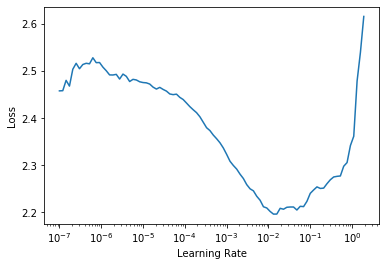

In [ ]:
#slow
learn.lr_find()

Then fit our model:

In [ ]:
#slow
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.563880,1.668477,0.480764,00:11
1,1.187707,1.145329,0.622930,00:12
2,0.969200,0.961843,0.692229,00:11
3,0.777063,0.785314,0.748280,00:11
4,0.673000,0.715555,0.767134,00:12


Wow this is a huge improvement! As we saw in all the application tutorials, we can then look at some results with:

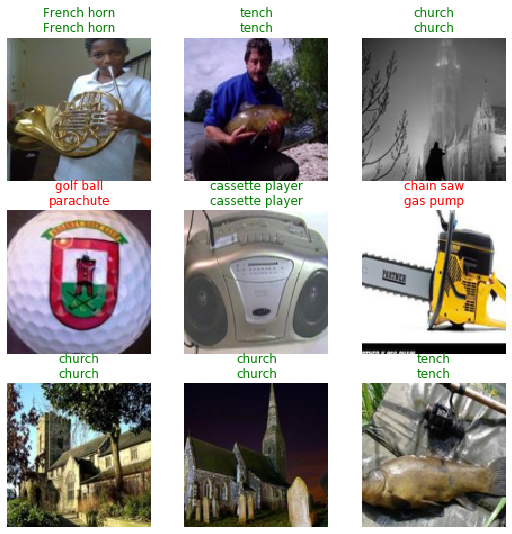

In [ ]:
learn.show_results()

Now let's see how to customize each bit of the training.

### Changing the loss function

The loss function you pass to a `Learner` is expected to take an output and target, then return the loss. It can be any regular PyTorch function and the training loop will work without any problem. What may cause problems is when you use fastai functions like `Learner.get_preds`, `Learner.predict` or `Learner.show_results`.

If you want `Learner.get_preds` to work with the argument `with_loss=True` (which is also used when you run`ClassificationInterpretation.plot_top_losses` for instance), your loss function will need a `reduction` attribute (or argument) that you can set to "none" (this is standard for all PyTorch loss functions or classes). With a reduction of "none", the loss function does not return a single number (like a mean or sum) but something the same size as the target.

As for `Learner.predict` or `Learner.show_results`, they internally rely on two methods your loss function should have:

- if you have a loss that combines activation and loss function (such as `nn.CrossEntropyLoss`), an `activation` function.
- a <code>decodes</code> function that converts your predictions to the same format your targets are: for instance in the case of `nn.CrossEntropyLoss`, the <code>decodes</code> function should take the argmax.

As an example, let's look at how to implement a custom loss function doing label smoothing (this is already in fastai as `LabelSmoothingCrossEntropy`).

In [ ]:
class LabelSmoothingCE(Module):
    def __init__(self, eps=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)

We won't comment on the `forward` pass that just implements the loss in itself. What is important is to notice how the `reduction` attribute plays in how the final result is computed.

Then since this loss function combines activation (softmax) with the actual loss, we implement `activation` that take the softmax of the output. This is what will make `Learner.get_preds` or `Learner.predict` return the actual predictions instead of the final activations.

Lastly, <code>decodes</code> changes the outputs of the model to put them in the same format as the targets (one int for each sample in the batch size) by taking the argmax of the predictions. We can pass this loss function to `Learner`:

In [ ]:
learn = Learner(dls, xresnet34(n_out=10), loss_func=LabelSmoothingCE(), metrics=accuracy)

In [ ]:
#slow
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.752499,1.620845,0.535796,00:11
1,1.427922,1.445637,0.610701,00:11
2,1.253892,1.305840,0.666242,00:11
3,1.116652,1.121115,0.752102,00:12
4,1.037727,1.076632,0.769427,00:12


It's not training as well as before because label smoothing is a regularizing technique, so it needs more epochs to really kick in and give better results.

After training our model, we can indeed use `predict` and `show_results` and get proper results:

In [ ]:
learn.predict(fnames[0])

('gas pump',
 tensor(6),
 tensor([0.0110, 0.0205, 0.0441, 0.0137, 0.0504, 0.0360, 0.7745, 0.0230, 0.0195,
         0.0072]))

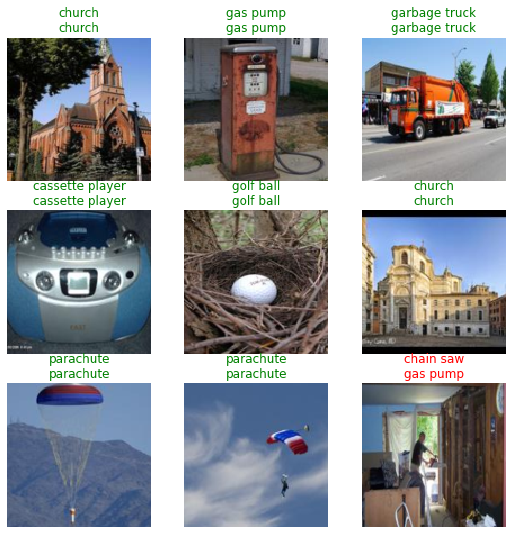

In [ ]:
learn.show_results()

### Changing the optimizer

fastai uses its own class of `Optimizer` built with various callbacks to refactor common functionality and provide a unique naming of hyperparameters playing the same role (like momentum in SGD, which is the same as alpha in RMSProp and beta0 in Adam) which makes it easier to schedule them (such as in `Learner.fit_one_cycle`).

It implements all optimizers supported by PyTorch (and much more) so you should never need to use one coming from PyTorch. Checkout the `optimizer` module to see all the optimizers natively available.

However in some circumstances, you might need to use an optimizer that is not in fastai (if for instance it's a new one only implemented in PyTorch). Before learning how to port the code to our internal `Optimizer` (checkout the `optimizer` module to discover how), you can use the `OptimWrapper` class to wrap your PyTorch optimizer and train with it:

In [ ]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(param_groups, **kwargs):
    return OptimWrapper(torch.optim.AdamW([{'params': ps, **kwargs} for ps in param_groups]))

We write an optimizer function that expects `param_groups`, which is a list of list of parameters. Then we pass those to the PyTorch optimizer we want to use.

We can use this function and pass it to the `opt_func` argument of `Learner`:

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3))

We can then use the usual learning rate finder:

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.004365158267319202)

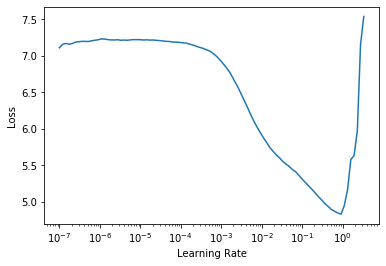

In [ ]:
#slow
learn.lr_find()

Or `fit_one_cycle` (and thanks to the wrapper, fastai will properly schedule the beta0 of AdamW).

In [ ]:
#slow
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.222441,2.555031,0.419108,00:09
1,2.290207,2.202564,0.575796,00:08
2,2.075831,2.144120,0.603567,00:08
3,1.925448,1.902397,0.704713,00:08
4,1.881001,1.880926,0.713121,00:09


### Changing the training loop with a `Callback`

The base training loop in fastai is the same as PyTorch's:

```python
for xb,yb in dl:
    pred = model(xb)
    loss = loss_func(pred, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
```
where `model`, `loss_func` and `opt` are all attributes of our `Learner`. To easily allow you to add new behavior in that training loop without needing to rewrite it yourself (along with all the fastai pieces you might want like mixed precision, 1cycle schedule, distributed training...), you can customize what happens in the training loop by writing a callback.

`Callback`s will be fully explained in an upcoming tutorial, but the basics are that:

- a `Callback` can read every piece of a `Learner`, hence knowing everything happening in the training loop
- a `Callback` can change any piece of the `Learner`, allowing it to alter the behavior of the training loop
- a `Callback` can even raise special exceptions that will allow breaking points (skipping a step, a validation phase, an epoch or even cancelling training entirely)

Here we will write a simple `Callback` applying [mixup](https://arxiv.org/abs/1710.09412) to our training (the version we will write is specific to our problem, use fastai's `MixUp` in other settings).

Mixup consists in changing the inputs by mixing two different inputs and making a linear combination of them:

``` python
input = x1 * t + x2 * (1-t)
```

Where `t` is a random number between 0 and 1. Then, if the targets are one-hot encoded, we change the target to be

``` python
target = y1 * t + y2 * (1-t)
```

In practice though, targets are not one-hot encoded in PyTorch, but it's equivalent to change the part of the loss dealing with `y1` and `y2` by
```python
loss = loss_func(pred, y1) * t + loss_func(pred, y2) * (1-t)
```
because the loss function used is linear with respect to y.

We just need to use the version with `reduction='none'` of the loss to do this linear combination, then take the mean.

Here is how we write mixup in a `Callback`:

In [ ]:
from torch.distributions.beta import Beta

In [ ]:
class Mixup(Callback):
    run_valid = False
    
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    
    def before_batch(self):
        self.t = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        x1,self.y1 = self.x[shuffle],self.y[shuffle]
        self.learn.xb = (x1 * (1-self.t[:,None,None,None]) + self.x * self.t[:,None,None,None],)
    
    def after_loss(self):
        with NoneReduce(self.loss_func) as lf:
            loss = lf(self.pred,self.y1) * (1-self.t) + lf(self.pred,self.y) * self.t
        self.learn.loss = loss.mean()

We can see we write two events:

- `before_batch` is executed just after drawing a batch and before the model is run on the input. We first draw our random numbers `t`, following a beta distribution (like advised in the paper) and get a shuffled version of the batch (instead of drawing a second version of the batch, we mix one batch with a shuffled version of itself). Then we set `self.learn.xb` to the new input, which will be the on fed to the model.
- `after_loss` is executed just after the loss is computed and before the backward pass. We replace `self.learn.loss` by the correct value. `NoneReduce` is a context manager that temporarily sets the reduction attribute of a loss to 'none'.

Also, we tell the `Callback` it should not run during the validation phase with `run_valid=False`.

To pass a `Callback` to a `Learner`, we use `cbs=`:

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(), cbs=Mixup(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3))

Then we can combine this new callback with the learning rate finder:

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.005248074419796467)

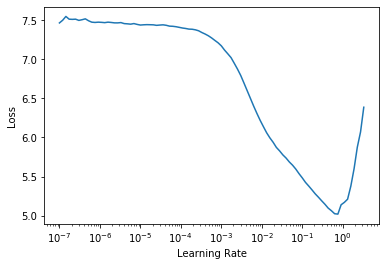

In [ ]:
#slow
learn.lr_find()

And combine it with `fit_one_cycle`:

In [ ]:
#slow
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.987924,2.508427,0.451465,00:09
1,2.480293,2.232779,0.593885,00:08
2,2.286732,2.082053,0.635159,00:10
3,2.162914,1.828538,0.726115,00:09
4,2.101327,1.752887,0.762293,00:09


Like label smoothing, this is a callback that provides more regularization, so you need to run more epochs before seeing any benefit. Also, our simple implementation does not have all the tricks of the fastai's implementation, so make sure to check the official one in `callback.mixup`!